# Train an Automated Machine Learning Model for Trash Recycling using Instance Segmentation

## Get the data


First of all, you will need to get the TACO trash dataset that we will use for model training. You can download it under the following link: http://tacodataset.org/ . Please follow the instructions of the GitHub repository to download the images and COCO annotation file. 

Once you obtain the images, it is recommended to upload them into your Azure ML Blob Storage associated to this AzureML workspace through Azure Storage Explorer. Azure Storage Explorer allows you to upload/download and organise your files through a UI. It also allows us to train our models more efficiently as we will later read the training files from the associated storage account directly rather than from the local upload pane on the left hand side. To download Azure Storage Explorer, follow the following link: https://azure.microsoft.com/en-us/products/storage/storage-explorer/ . 

## 1. Setup & Dependencies

You might need to go into the terminal and execute `conda activate azureml_py38_PT_TF` and then pip install your packages. Make sure you use the Python 3.8 - Pytorch and Tensorflow kernel

Then, copy the requirements.txt, navigate into the folder where the file is located and execute `pip install -r requirements.txt` in the terminal to install the dependencies. 

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
from pathlib import Path

# Import required libraries
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient

from azure.ai.ml.constants import AssetTypes
from azure.ai.ml import Input


from azure.ai.ml.entities import Data
from azure.ai.ml.constants import InputOutputModes
from azure.ai.ml import automl

# IMPORT CUSTOM FUNCTION LIBRARY
from utils import *


## 1. Configure ML Client

In [3]:
credential = DefaultAzureCredential()
ml_client = None

try:
    ml_client = MLClient.from_config(credential=credential)
except Exception as ex:
    # NOTE: Update following workspace information if not correctly configure before
    client_config = {
        "subscription_id": "<SUBSCRIPTION ID>",
        "resource_group": "<RG_NAME>",
        "workspace_name": "<WORKSPACENAME>",
    }
    if client_config["subscription_id"].startswith("<"):
        print(
            "please update your <SUBSCRIPTION_ID> <RESOURCE_GROUP> <AML_WORKSPACE_NAME> in notebook cell"
        )
        raise ex
    else:  # write and reload from config file
        import json, os
        config_path = "../.azureml/config.json"
        os.makedirs(os.path.dirname(config_path), exist_ok=True)
        with open(config_path, "w") as fo:
            fo.write(json.dumps(client_config))
        ml_client = MLClient.from_config(credential=credential, path=config_path)
print(ml_client)

Found the config file in: ./.azureml/config.json


## 2. Connect files from Storage Account into Azure Machine Learning Studio as versioned data asset

An overall explanation can be found under: https://learn.microsoft.com/en-us/azure/machine-learning/how-to-create-data-assets?tabs=cli . Please have a look at the specific visual summary for the TACO dataset in the image below. In a new tab, **please naviagte to the data tab in your Azure ML Studio on the left hand side and follow the steps as below. In this tutorial, we will register the dataset as "coco_tabular_trash_data"**

<img src="media/link_dataset_from_storage_to_azureml.jpg" width="800"/>

## 1. Read data from datastore

In [4]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset, Datastore
import json

workspace = Workspace.from_config()
datastore = workspace.get_default_datastore()

annotations = Dataset.get_by_name(workspace, name='coco_tabular_trash_data')
annotations = annotations.to_pandas_dataframe()

#Convert back to .json file
annotations = json.loads(annotations["Line"][0])

#create new data directory
Path(f"./data").mkdir(parents=True, exist_ok=True)

with open('./data/TACO_data.json', 'w+') as f:
    json.dump(annotations, f)


You should now see the `./data/TACO_data.json` file in you document tree

## 2 Convert files into JSONL

Azure Automated Machine Learning requires JSONL files. Please refer to the following documentation for more details: https://learn.microsoft.com/en-us/azure/machine-learning/reference-automl-images-schema

```
{
   "image_url":"azureml://subscriptions/<my-subscription-id>/resourcegroups/<my-resource-group>/workspaces/<my-workspace>/datastores/<my-datastore>/paths/<path_to_image>",
   "image_details":{
      "format":"image_format",
      "width":"image_width",
      "height":"image_height"
   },
   "label":[
      {
         "label":"class_name",
         "isCrowd":"isCrowd",
         "polygon":[["x1", "y1", "x2", "y2", "x3", "y3", "...", "xn", "yn"]]
      }
   ]
}

In [5]:
base_path = "azureml://subscriptions/<subscriptionid>/resourcegroups/<resouce_group>/workspaces/<workspacename>/datastores/workspaceblobstore/paths/<path of TACO dataset>"
# base path should end with "TACO_Images/data"


# Convert files into JSONL format required for AutoML. This function comes from utils
# Function can run up to a minute
generate_jsonl_annotations(source=annotations, target_path=base_path, annotation_file="./data/TACO_segmentation.jsonl")

You should now see the `./data/TACO_segmentation.jsonl` file in you document tree

## 3. Split JSONL into train and evaluation sets
First, we'll need to split the images into train and eval sets. We'll put aside 20% of the data for evaluation and will use random sampling to split the datasets.
To better analyse the label distributions, we will create a pandas dataframe that shows us the overall distribution of the trash classes present.

In [6]:
import json

with open('./data/TACO_segmentation.jsonl', 'r') as json_file:
    json_list = list(json_file)
df_jsonl = pd.DataFrame(json_list)

urls = []
labels = []
image_id = []

for ii in range(len(df_jsonl)):
    url = json.loads(df_jsonl[0][ii])["image_url"]
    l = json.loads(df_jsonl[0][ii])["label"]
    id = json.loads(df_jsonl[0][ii])["image_url"][-10:]
    for jj in range(len(l)):
        labels.append(l[jj]["label"])
        urls.append(url)
        image_id.append(id)

df = pd.DataFrame([urls, labels, image_id]).T
df.columns = ["url", "label", "image_id"]


## 3.1. Test-train split 

In [10]:
# split random samples
#For testing if you want to limit the data to a smaller subset -> remove the variable smaller subset an replace with df for full model training
#smaller_subset = df.sample(frac=0.2)

train = df.sample(frac=0.8)
test = df[~df.index.isin(list(train.index))]
assert len(train) + len(test) == len(df)

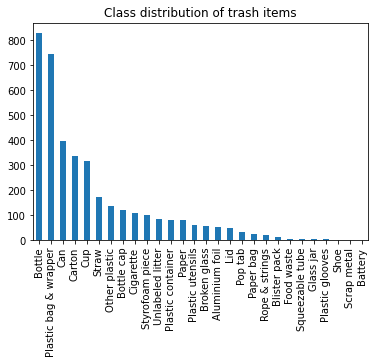

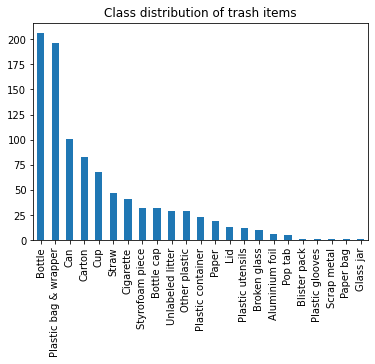

In [12]:
# Sanity check for similar class distributions between training and evaluation set

for i in [train, test]:
    i.label.value_counts().plot(kind="bar")
    plt.title("Class distribution of trash items")
    plt.show()

The distributions looks similar and we can now move on to save the datasets into our workspace blov storage for later consumption within AutoML 

## 3.2. Reformat test/train partitions into JSONL which is the necessary AutoML training file format

In [13]:
from pathlib import Path

train_dict = []
test_dict = []
train_images = list(train["url"])
test_images = list(test["url"])
df_len = len(json_list)

for ii in range(df_len):
    tt = json.loads(json_list[ii])["image_url"]
    if tt in train_images:
        train_dict.append(json.loads(json_list[ii]))
    if tt in test_images:
        test_dict.append(json.loads(json_list[ii]))


In [14]:

#LOCAL UPLOAD INTO FILESHARE
train_path = "./data/train_formatted"
validation_path = "./data/validation_formatted"

Path(train_path).mkdir(parents=True, exist_ok=True)
Path(validation_path).mkdir(parents=True, exist_ok=True)

with open(f'{train_path}/training_data.jsonl', 'w') as f:
    for item in train_dict:
        f.write(json.dumps(item) + "\n")


with open(f'{validation_path}/eval_data.jsonl', 'w') as f:
    for item in test_dict:
        f.write(json.dumps(item) + "\n")

# 3.3. Write MLTable files as those are the neseccary metadata files for AutoML model training

In [15]:
%%writefile ./data/train_formatted/MLTable
paths:
  - file: ./training_data.jsonl
transformations:
  - read_json_lines:
        encoding: utf8
        invalid_lines: error
        include_path_column: false
  - convert_column_types:
      - columns: image_url
        column_type: stream_info

Writing ./data/train_formatted/MLTable


In [16]:
%%writefile ./data/validation_formatted/MLTable
paths:
  - file: ./eval_data.jsonl
transformations:
  - read_json_lines:
        encoding: utf8
        invalid_lines: error
        include_path_column: false
  - convert_column_types:
      - columns: image_url
        column_type: stream_info

Writing ./data/validation_formatted/MLTable


# 4. Upload data into Blobstorage

In [17]:
# UPLOAD INTO DATASTORE 

my_data_train = Data(
    path=train_path,
    type=AssetTypes.URI_FOLDER,
    description="train_formatted",
    name="train_trash_jsonl",
)

my_data_val = Data(
    path=validation_path,
    type=AssetTypes.URI_FOLDER,
    description="val_formatted",
    name="val_trash_jsonl",
)


uri_folder_data_asset_train = ml_client.data.create_or_update(my_data_train)
uri_folder_data_asset_val = ml_client.data.create_or_update(my_data_val)

print(uri_folder_data_asset_train)
print("")
print("Path to folder in Blob Storage:")
print(uri_folder_data_asset_train.path)

print(uri_folder_data_asset_val)
print("")
print("Path to folder in Blob Storage:")
print(uri_folder_data_asset_val.path)

Uploading train_formatted (4.99 MBs): 100%|██████████| 4994184/4994184 [00:00<00:00, 17033715.06it/s]


Uploading validation_formatted (2.82 MBs): 100%|██████████| 2817566/2817566 [00:00<00:00, 37884619.94it/s]


